In [13]:
#Notebook stuff
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

#Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin

#Model evaluation, selection, metrics, and saving.
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.externals import joblib

#schikit models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, Ridge, Lasso, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
import lightgbm as lgb

In [2]:
%%time
train = pd.read_csv('train.csv')

Wall time: 11.5 s


In [3]:
#Save a copy.
train_copy = train.copy()

In [4]:
train.shape
#train.head()

(200000, 202)

In [5]:
X = train.iloc[:,2:]
y = train.iloc[:,1]
#X.shape
#X.head()
#y.shape
#y.head()

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=42)

In [17]:
#X_train.shape
#X_test.shape
#y_train.shape
#y_test.shape

In [12]:
######################################################################################################################
######################################################################################################################
######################################################################################################################
#############Code for Naive Bayes###################
pipeline = make_pipeline(QuantileTransformer(output_distribution='normal'), GaussianNB())
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('quantiletransformer', QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
          output_distribution='normal', random_state=None,
          subsample=100000)), ('gaussiannb', GaussianNB(priors=None))])

In [13]:
cross_val_score(pipeline, X_train, y_train, scoring='roc_auc', cv=10).mean()

0.8894234103828369

In [14]:
y_pred = pipeline.predict(X_test)

In [6]:
######################################################################################################################
######################################################################################################################
######################################################################################################################
########################################Random Forest#####################################################
#############Performing random grid search for random forest, for all variables, unstandardized, using the AUC metric###############
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, confusion_matrix

#Tuning the hyperparameters of Forest 
#Grid from here: (https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)
#I modified the values quite a bit.
#Also see: https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 250, num = 5)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 55, num = 5)]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20, 50, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20, 50, 100, 200, 300]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
display(random_grid)

{'n_estimators': [10, 70, 130, 190, 250],
 'max_features': ['sqrt', 'log2'],
 'max_depth': [5, 17, 30, 42, 55],
 'min_samples_split': [5, 10, 20, 50, 100],
 'min_samples_leaf': [5, 10, 20, 50, 100, 200, 300],
 'bootstrap': [True, False]}

In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
score = 'roc_auc'
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 50, cv = 4, scoring = score, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
rf_random.best_score_
rf_random.best_params_
#rf_random.best_estimator_

In [5]:
#Tuning the hyperparameters of Forest using grid search
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [500,750]
# Number of features to consider at every split
max_features = [5,'log2']
# Maximum number of levels in tree
max_depth = [55,75]
#max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [20]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2,5,10]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
display(param_grid)

{'n_estimators': [500, 750],
 'max_features': [5, 'log2'],
 'max_depth': [55, 75],
 'min_samples_split': [20],
 'min_samples_leaf': [2, 5, 10],
 'bootstrap': [True]}

In [7]:
#Grid Search.
score = 'roc_auc'
rf = RandomForestClassifier()
rf_grid = GridSearchCV(estimator = rf, param_grid = param_grid, 
                       cv = 2, n_jobs = -1, verbose = 2, scoring = score)
rf_grid.fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 77.4min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed: 138.9min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [500, 750], 'max_features': [5, 'log2'], 'max_depth': [55, 75], 'min_samples_split': [20], 'min_samples_leaf': [2, 5, 10], 'bootstrap': [True]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [9]:
rf_grid.best_score_
rf_grid.best_params_
#rf_grid.best_estimator_

0.8728381794677282

{'bootstrap': True,
 'max_depth': 75,
 'max_features': 5,
 'min_samples_leaf': 10,
 'min_samples_split': 20,
 'n_estimators': 750}

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=75, max_features=5, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=20,
            min_weight_fraction_leaf=0.0, n_estimators=750, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [19]:
display(pd.DataFrame(rf_grid.cv_results_).sort_values(by='mean_test_score', ascending=False))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
17,1188.121302,4.090624,23.246833,0.053401,True,75,5,10,20,750,"{'bootstrap': True, 'max_depth': 75, 'max_feat...",0.871465,0.874211,0.872838,0.001373,1,0.999997,0.999996,0.999997,5.028113e-07
5,1171.808834,9.128552,23.502392,0.069870,True,55,5,10,20,750,"{'bootstrap': True, 'max_depth': 55, 'max_feat...",0.869520,0.874596,0.872058,0.002538,2,0.999996,0.999997,0.999996,3.661838e-07
4,788.493998,8.228735,15.833131,0.247540,True,55,5,10,20,500,"{'bootstrap': True, 'max_depth': 55, 'max_feat...",0.868902,0.873614,0.871258,0.002356,3,0.999997,0.999996,0.999996,3.529083e-07
16,802.589767,3.664433,15.735285,0.138742,True,75,5,10,20,500,"{'bootstrap': True, 'max_depth': 75, 'max_feat...",0.869426,0.872270,0.870848,0.001422,4,0.999995,0.999997,0.999996,6.781592e-07
15,1282.170920,6.498678,24.927966,0.083598,True,75,5,5,20,750,"{'bootstrap': True, 'max_depth': 75, 'max_feat...",0.869149,0.872466,0.870808,0.001659,5,1.000000,1.000000,1.000000,4.425182e-09
3,1242.880284,10.224535,25.404377,0.364822,True,55,5,5,20,750,"{'bootstrap': True, 'max_depth': 55, 'max_feat...",0.869142,0.872150,0.870646,0.001504,6,1.000000,1.000000,1.000000,4.978330e-09
2,826.366044,1.867286,17.262984,0.169685,True,55,5,5,20,500,"{'bootstrap': True, 'max_depth': 55, 'max_feat...",0.867893,0.869358,0.868626,0.000732,7,1.000000,1.000000,1.000000,7.522810e-08
14,851.876784,7.341622,16.912356,0.376052,True,75,5,5,20,500,"{'bootstrap': True, 'max_depth': 75, 'max_feat...",0.867131,0.869501,0.868316,0.001185,8,1.000000,1.000000,1.000000,7.467495e-08
23,1276.523667,20.226698,17.164868,0.199389,True,75,log2,10,20,750,"{'bootstrap': True, 'max_depth': 75, 'max_feat...",0.865134,0.869452,0.867293,0.002159,9,0.999990,0.999990,0.999990,2.594263e-07
13,1408.033100,9.402028,27.385655,0.125768,True,75,5,2,20,750,"{'bootstrap': True, 'max_depth': 75, 'max_feat...",0.866001,0.867989,0.866995,0.000994,10,1.000000,1.000000,1.000000,0.000000e+00


In [75]:
%%time
#Trying to do a bit better.
score = 'roc_auc'
Forest = RandomForestClassifier(n_estimators=1000, max_features=4, max_depth=100, min_samples_split=20, min_samples_leaf=10, bootstrap=True, random_state=0)
ForestScores5 = cross_val_score(Forest, X_train, y_train, cv=2, n_jobs=-1, scoring=score)
print("CV iterations: {}\nAUC mean: {:.3f}\nAUC std: {:.3f}".format(len(ForestScores5), ForestScores5.mean(), ForestScores5.std()))

CV iterations: 2
AUC mean: 0.877
AUC std: 0.002
Wall time: 11min 32s


In [ ]:
#######################Final forest model with predictions and submission (ForestScores5)#################
Forest = RandomForestClassifier(n_estimators=1000, max_features=4, max_depth=100, min_samples_split=20, min_samples_leaf=10, bootstrap=True, random_state=0)
ForestModel = Forest.fit(X_train, y_train)
y_pred = ForestModel.predict_proba(X_test)

In [ ]:
######################################################################################################################
######################################################################################################################
######################################################################################################################
###################################Logistic regression#############################

In [ ]:
###Custom transformer for feature engineering.
class FeatureEngineering(BaseEstimator, TransformerMixin):          
    #Class Constructor 
    def __init__(self, agg=1):
        self.agg = agg
    
    #Return self nothing else to do here    
    def fit(self, X, y = None):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform(self, X, y = None):
        X = pd.DataFrame(X)
        if self.agg == 1:
            return X.values
        elif self.agg == 2:
            idx =  X.columns.values[2:202]             
            X['sum'] = X[idx].sum(axis=1)  
            X['min'] = X[idx].min(axis=1)
            X['max'] = X[idx].max(axis=1)
            X['mean'] = X[idx].mean(axis=1)
            X['std'] = X[idx].std(axis=1)
            X['skew'] = X[idx].skew(axis=1)
            X['kurt'] = X[idx].kurtosis(axis=1)
            X['med'] = X[idx].median(axis=1)
            return X.values
        elif self.agg == 3:
            idx =  X.columns.values[2:202]
            X['sum'] = X[idx].sum(axis=1)  
            X['min'] = X[idx].min(axis=1)
            X['max'] = X[idx].max(axis=1)
            X['mean'] = X[idx].mean(axis=1)
            X['std'] = X[idx].std(axis=1)
            X['skew'] = X[idx].skew(axis=1)
            X['kurt'] = X[idx].kurtosis(axis=1)
            X['med'] = X[idx].median(axis=1)
            X = X.iloc[:,-8:]
            return X.values

In [ ]:
pipe = Pipeline([('preprocessing', StandardScaler()), 
                 ('featureengineering', FeatureEngineering(agg=2)),
                 ('classifier', LogisticRegression(C=10, max_iter=1000, random_state=0, solver='sag'))])

In [ ]:
pipe.fit(X_train, y_train)
roc_auc_score(y_test, pipe.predict_proba(X_test)[:,1])

In [ ]:
#sag is supposed to be faster for bigger datasets. However, it failed to converge with the default iteration of 100.
from sklearn.model_selection import GridSearchCV
C=[.01, .1, 1.0, 10]
solver='sag',
log_param_grid = {'C': C,
                  'solver': solver,
                  'max_iter': [1000]}
display(log_param_grid)

In [41]:
#Note sure sag is saving time. I didn't try the default.
%%time
score = 'roc_auc'
logreg = LogisticRegression()
log_grid = GridSearchCV(estimator = logreg, param_grid = log_param_grid, 
                       cv = 4, n_jobs = -1, verbose = 2, scoring = score)
log_grid.fit(X_train, y_train)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=-1)]: Done  10 out of  16 | elapsed: 13.1min remaining:  7.9min
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed: 17.2min finished


Wall time: 24min 7s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [43]:
log_grid.best_score_
log_grid.best_params_
#log_grid.best_estimator_

0.8589207492206489

{'C': 10, 'max_iter': 1000, 'solver': 'sag'}

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False)

In [45]:
display(pd.DataFrame(log_grid.cv_results_).sort_values(by='mean_test_score', ascending=False))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\util

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_max_iter,param_solver,params,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
3,445.169238,2.747545,0.035933,0.003786,10,1000,sag,"{'C': 10, 'max_iter': 1000, 'solver': 'sag'}",0.853232,0.857573,...,0.864499,0.858921,0.004105,1,0.862906,0.861501,0.860500,0.859271,0.861045,0.001334
2,569.194663,0.870682,0.043544,0.001880,1,1000,sag,"{'C': 1.0, 'max_iter': 1000, 'solver': 'sag'}",0.853202,0.857554,...,0.864487,0.858893,0.004109,2,0.862877,0.861471,0.860474,0.859240,0.861016,0.001334
1,574.151204,3.182388,0.172929,0.051861,0.1,1000,sag,"{'C': 0.1, 'max_iter': 1000, 'solver': 'sag'}",0.852913,0.857315,...,0.864309,0.858609,0.004132,3,0.862588,0.861180,0.860223,0.858927,0.860730,0.001338
0,215.111313,2.580298,0.169311,0.013140,0.01,1000,sag,"{'C': 0.01, 'max_iter': 1000, 'solver': 'sag'}",0.851654,0.856365,...,0.863157,0.857400,0.004132,4,0.861363,0.859937,0.859121,0.857636,0.859514,0.001349


In [ ]:
######################################################################################################################
######################################################################################################################
######################################################################################################################
###################################Gradient boosted tree#############################

In [5]:
#Grid search.
n_estimators=[450, 550]
learning_rate=[2, 1, .01]
max_depth=[1, 2]
param_grid = {'n_estimators': n_estimators,
               'learning_rate': learning_rate,
               'max_depth': max_depth}
display(param_grid)

{'n_estimators': [450, 550],
 'learning_rate': [2, 1, 0.01],
 'max_depth': [1, 2]}

In [6]:
score='roc_auc'
gbc = GradientBoostingClassifier()
rf_grid = GridSearchCV(estimator = gbc, param_grid = param_grid, cv = 2, scoring = score, verbose=2, n_jobs = -1)
rf_grid.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed: 68.1min remaining:  6.2min
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 70.9min finished


GridSearchCV(cv=2, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [450, 550], 'learning_rate': [2, 1, 0.01], 'max_depth': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [7]:
rf_grid.best_score_
rf_grid.best_params_

0.8816425550090435

{'learning_rate': 1, 'max_depth': 1, 'n_estimators': 550}

In [ ]:
######################################################################################################################
######################################################################################################################
######################################################################################################################
###################################Adaboost#############################

In [7]:
%%time
score = 'roc_auc'
ada = AdaBoostClassifier(n_estimators=350, learning_rate=1, random_state=0) 
adaScores4 = cross_val_score(ada, X_train, y_train, cv=2, n_jobs=-1, scoring=score)
print("CV iterations: {}\nAUC mean: {:.3f}\nAUC std: {:.3f}".format(len(adaScores4), adaScores4.mean(), adaScores4.std()))

CV iterations: 2
AUC mean: 0.877
AUC std: 0.000
Wall time: 19min 42s


In [12]:
%%time
score = 'roc_auc'
ada = AdaBoostClassifier(n_estimators=500, learning_rate=1, random_state=0) 
ada_fit = ada.fit(X_train, y_train)

Wall time: 49min 41s


In [16]:
#Saving the model.
# Output a pickle file for the model
joblib.dump(ada_fit, 'adamodel_fit_350.pkl') 

['adamodel_fit_350.pkl']

In [17]:
# Load the pickle file
ada_load = joblib.load('adamodel_fit_350.pkl') 
 
# Check that the loaded model is the same as the original
assert ada.score(X_train, y_train) == ada_load.score(X_train, y_train)

In [14]:
######################################################################################################################
######################################################################################################################
######################################################################################################################
######################################XGboost#####################################################
xgb_model = xgb.XGBClassifier(objective="binary:logistic", n_estimators = 500, random_state=42)
xgb.fit = xgb_model.fit(X_train, y_train)

In [20]:
#Saving the model.
# Output a pickle file for the model
joblib.dump(xgb.fit, 'xgbmodel_fit_350.pkl') 

['xgbmodel_fit_350.pkl']

In [ ]:
# Load the pickle file
xgb_load = joblib.load('xgbmodel_fit_350.pkl') 
 
# Check that the loaded model is the same as the original
assert xgb.score(X_train, y_train) == xgb_load.score(X_train, y_train)

In [ ]:
aucList = []
fpr, tpr, thr = roc_curve(y_test, ada_load.predict_proba(X_test)[:,1])
aucList.append(auc(fpr, tpr))
plt.plot(fpr, tpr, label='adaboost')
fpr, tpr, thr = roc_curve(y_test, xgb_load.predict_proba(X_test)[:,1])
aucList.append(auc(fpr, tpr))
plt.plot(fpr, tpr, label='xgbboost')

In [ ]:
######################################################################################################################
######################################################################################################################
######################################################################################################################
######################################All Tuned Models#####################################################

In [18]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

StandardScaler(copy=True, with_mean=True, with_std=True)

C:\Users\Curt\Anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Text(0.5,0,'False Positive Rate')

Text(0,0.5,'True Positive Rate')

Text(0.5,1,'Receiver Operating Characteristic Plot')

,Model,AUC Score
0,Log,0.858876
1,Tree,0.653011
2,Forest,0.876505
3,GradientBoost,0.888013
4,AdaBoost,0.884841
5,XGBoost,0.884671


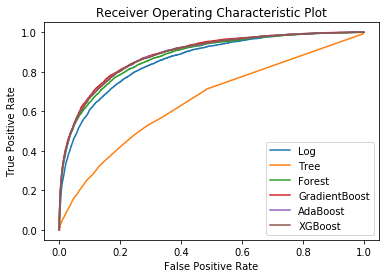

In [28]:
#I think I need to split into train and test first to avoid just giving AUC curves for the training data itself.
#%%time
classifiers = [
    #("NaiveBayes", GaussianNB()),
    #("svc", SVC(random_state=0)),   
    #("per", Perceptron())        Doesn't work because no .predict_proba
    #("knn", KNeighborsClassifier(n_neighbors=3)    Takes too long
    ("Log", LogisticRegression(C=10, max_iter=1000, random_state=0, solver='sag')),
    #("ridge", Ridge(alpha=0.5, max_iter=None, normalize=True, random_state=0, solver='auto', tol=0.001)),
    #("lasso", Lasso(alpha=0.001, max_iter=100000,normalize=True, random_state=0, tol=0.0001)),
    #("sgd", SGDClassifier(loss='log', random_state=0)),
    
    ("Tree", DecisionTreeClassifier(max_depth=8, random_state=0)),
    ("Forest", RandomForestClassifier(n_estimators=1000, max_features=4, max_depth=100, min_samples_split=20, min_samples_leaf=10, bootstrap=True, random_state=0)),
    ("GradientBoost", GradientBoostingClassifier(n_estimators=600, max_depth=1, learning_rate=1, random_state=0)),
    ("AdaBoost", AdaBoostClassifier(n_estimators=350, learning_rate=1, random_state=0)), 
    ("XGBoost", xgb.XGBClassifier(objective="binary:logistic", n_estimators = 500, random_state=42))
]

modelNameList = []
aucList = []
cvMeanList = []
cvSTDList = []
     
for name, clf in classifiers:
    modelNameList.append(name)
     
    fitted = clf.fit(X_train, y_train)
    fpr, tpr, thr = roc_curve(y_test, fitted.predict_proba(X_test)[:,1])
    aucList.append(auc(fpr, tpr))
    
    plt.plot(fpr, tpr, label=name)
    
    #rng = np.random.RandomState(42)
    #cvScores = cross_val_score(clf, X_train, y_train, scoring='roc_auc', cv=4, n_jobs = -1) 
    #cvMean = cvScores.mean()
    #cvMeanList.append(cvMean)
    #cvSTD = cvScores.std()                           
    #cvSTDList.append(cvSTD)
     
plt.legend(loc="best")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Plot')
   
ModelResultsSummary = pd.DataFrame()
ModelResultsSummary['Model'] = modelNameList
ModelResultsSummary['AUC Score'] = aucList
#ModelResultsSummary['AUC Score_Cross Validation'] = cvMeanList
#ModelResultsSummary['AUC STD_Cross Validation'] = cvSTDList
#ModelResultsSummary.sort_values(by='AUC Score_Cross Validation', ascending=False).reset_index(drop=True)
display(ModelResultsSummary)
#Code from here helped: https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_comparison.html